In [112]:
# -*- coding: utf-8 -*-
import os
import sys
import time
import pandas as pd
import numpy as np
import torch
from torch.optim import Adagrad
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor

sys.path.append("/Users/wzq/Desktop/game")
from deepctr_torch.inputs import get_feature_names
from deepctr_torch.models import *
from deepctr_torch.callbacks import EarlyStopping

from utils import *

# jupyter配置
from IPython.display import display
pd.options.display.max_rows=10000 #Notebook 的一个cell的显示行数
pd.options.display.max_columns=100000#Notebook 的一个cell的显示列数
pd.set_option('display.max_colwidth', None)

## 训练

In [129]:
data = pd.read_csv('./data/data_processed_v8.csv')
print(data.shape)
for f in range(len(data.columns)):
    print(data.columns[f], end=",")
    if f % 20 == 0:
        print()

# features = [f for f in data.columns if f not in ["id", "isDefault", "earliesCreditLine", "policyCode", "issueDate"]]
features = used_features
train_size = 800000
target = data.iloc[:train_size, :]['isDefault']
data = data[features]
train_data = data.iloc[:train_size, :]
test_data = data.iloc[train_size:, :]

display(train_data.shape)
display(train_data.head(10))
# display(test_data.shape)
# display(test_data.head(10))
# display(target.shape)
# display(target.head(10))

(1000000, 100)
loanAmnt,
term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,
pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,
n13,n14,issueDate_year,issueDate_month,issueDate_weekday,issueDate_is_weekend,earliesCreditLine_year,earliesCreditLine_month,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,
grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,gra

(800000, 50)

,employmentTitle_target_mean,postCode_target_mean,dti,title_target_mean,revolBal,installment,loanAmnt,revolUtil,annualIncome,interestRate,employmentTitle,ficoRangeLow,issueDate_year,totalAcc,postCode,earliesCreditLine_year,regionCode_target_mean,regionCode,subGrade,issueDate_month,homeOwnership_target_mean,employmentLength,n8,grade_to_std_earliesCreditLine_year,n14,n6,term,grade_to_std_n6,n2,grade_to_mean_n6,grade_to_std_n8,grade_to_mean_earliesCreditLine_year,grade_to_mean_issueDate_month,n5,grade_to_mean_issueDate_year,grade_to_mean_earliesCreditLine_month,grade_to_std_issueDate_month,grade_to_mean_n8,n9,title,grade_to_mean_n7,grade_to_std_earliesCreditLine_month,grade_to_mean_n10,earliesCreditLine_month,grade_to_std_n5,openAcc,grade_to_std_n10,grade_to_std_issueDate_year,grade_to_std_n7,delinquency_2years
0,0.165923,0.193253,0.01805,0.305068,0.008323,0.531301,0.873418,0.054802,0.010001,0.553349,305,0.477273,2014,0.15625,137,2001,0.593876,32,21,7,0.677699,0.2,0.086614,0.613154,0.066667,0.060606,1.0,0.608795,0.031746,0.430800,0.452596,0.628293,1.000000,0.128571,1.000000,0.000000,0.659961,0.348829,0.044444,1,0.293901,0.141303,0.291209,8,0.555929,0.077778,0.587947,0.535197,0.449355,0.0
1,0.200000,0.154922,0.02883,0.071429,0.005197,0.263246,0.443038,0.043595,0.004182,0.513240,176661,0.340909,2012,0.10000,156,2002,0.187106,18,16,8,0.241053,0.5,0.094488,0.609660,0.066667,0.053030,1.0,0.623751,0.079365,0.413495,0.467279,0.651467,0.811324,0.100000,0.255342,0.590997,0.918379,0.328894,0.111111,1509,0.280693,0.053614,0.290663,5,0.566717,0.144444,0.608813,0.456674,0.461781,0.0
2,0.000000,0.202395,0.02377,0.217977,0.001586,0.167014,0.291139,0.058052,0.006728,0.454829,27721,0.227273,2015,0.15625,337,2006,0.481426,14,17,10,0.241053,0.8,0.031496,0.607516,0.133333,0.159091,1.0,0.628093,0.047619,0.449356,0.453946,0.750923,0.256691,0.000000,0.590305,0.590997,0.412023,0.381035,0.066667,0,0.293901,0.053614,0.280038,5,0.568480,0.122222,0.620512,0.475171,0.449355,0.0
3,0.500000,0.237750,0.01821,0.175291,0.003425,0.192164,0.265823,0.058949,0.010728,0.075935,40375,0.272727,2015,0.16250,148,1999,0.593296,11,3,8,0.970365,1.0,0.157480,0.610010,0.033333,0.030303,0.0,0.598943,0.095238,0.433449,0.457404,0.596979,0.811324,0.228571,0.590305,0.590997,0.918379,0.336039,0.133333,4,0.280693,0.053614,0.292169,5,0.560544,0.100000,0.596108,0.475171,0.461781,0.0
4,0.261740,0.207317,0.03316,0.241175,0.001013,0.051169,0.063291,0.035862,0.002637,0.299065,51,0.295455,2016,0.15625,301,1977,0.622283,21,11,3,0.970365,0.6,0.110236,0.586347,0.133333,0.068182,0.0,0.612976,0.111111,0.433534,0.455415,0.349217,0.176211,0.057143,0.627398,0.000000,0.755505,0.344249,0.155556,11,0.291269,0.141303,0.291543,8,0.551970,0.133333,0.606679,0.365689,0.457915,0.0
5,0.000000,0.220653,0.01814,0.225882,0.001393,0.194333,0.265823,0.034854,0.003546,0.104361,44407,0.477273,2017,0.31250,512,1998,0.622283,21,4,4,0.241053,0.7,0.015748,0.610596,0.000000,0.363636,0.0,0.608788,0.031746,0.440171,0.459300,0.578564,0.455070,0.014286,0.793621,0.706327,0.733250,0.404853,0.044444,10,0.304202,0.527329,0.289035,7,0.560546,0.211111,0.624044,0.407642,0.456494,0.0
6,0.000000,0.189843,0.01849,0.217977,0.001071,0.029352,0.039241,0.009526,0.003182,0.092679,146449,0.590909,2014,0.13125,517,2006,0.481426,14,3,10,0.241053,0.9,0.133858,0.607516,0.100000,0.022727,0.0,0.599434,0.047619,0.436318,0.457785,0.750923,0.256691,0.157143,1.000000,0.547306,0.412023,0.340008,0.066667,0,0.291269,0.000000,0.291543,10,0.560266,0.133333,0.606679,0.535197,0.457915,0.0
7,0.000000,0.206147,0.03360,0.217977,0.004827,0.226007,0.278481,0.066906,0.002727,0.376558,172154,0.181818,2014,0.19375,100,1994,0.479530,4,12,1,0.970365,0.1,0.157480,0.610477,0.066667,0.075758,0.0,0.618086,0.063492,0.434839,0.457404,0.557965,0.086784,0.228571,1.000000,0.893426,0.443669,0.336039,0.088889,0,0.291715,0.119684,0.292515,12,0.560544,0.088889,0.592224,0.535197,0.447996,0.0
8,0.221364,0.212121,0.02022,0.217977,0.009355,0.229374,0.291139,0.051552,0.005455,0.29906

************************************ 1 ************************************
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.891124	valid_1's auc: 0.88688
[40]	training's auc: 0.896194	valid_1's auc: 0.889348
[60]	training's auc: 0.900101	valid_1's auc: 0.890447
[80]	training's auc: 0.903278	valid_1's auc: 0.890871
[100]	training's auc: 0.905899	valid_1's auc: 0.891008
[120]	training's auc: 0.908233	valid_1's auc: 0.891005
[140]	training's auc: 0.91051	valid_1's auc: 0.890993
[160]	training's auc: 0.912562	valid_1's auc: 0.890974
Early stopping, best iteration is:
[126]	training's auc: 0.908911	valid_1's auc: 0.891021
[0.8910205219738425]
************************************ 2 ************************************
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.891302	valid_1's auc: 0.885382
[40]	training's auc: 0.896512	valid_1's auc: 0.888146
[60]	training's auc: 0.90027	valid_1's auc: 0.889396
[80]	training's auc:

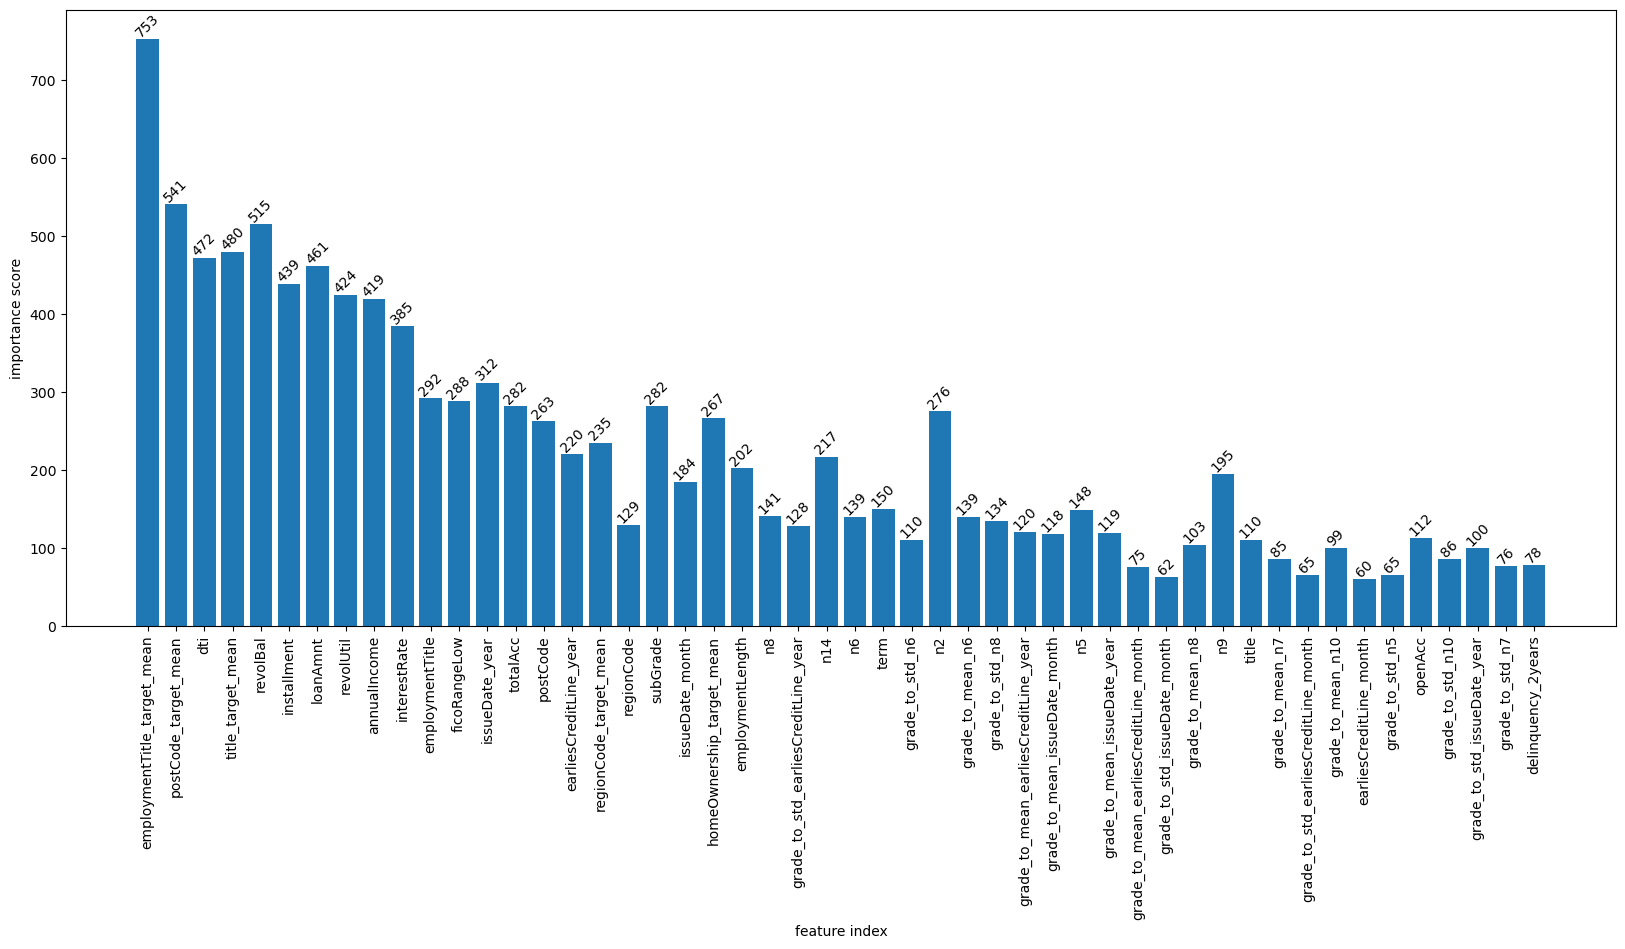

In [130]:
lgb_train, lgb_test, model = lgb_model(train_data, target, test_data)
# xgb_train, xgb_test = xgb_model(train_data, target, test_data)
# cat_train, cat_test = cat_model(train_data, target, test_data)

def get_feature_importance_pair(gbm_model):
    feature_name_list = gbm_model.feature_name()
    importance_list = list(gbm_model.feature_importance())
    feature_importance_pair = [(fe, round(im, 2)) for fe, im in zip(feature_name_list, importance_list)]
    # 重要性从高到低排序
    feature_importance_pair = sorted(feature_importance_pair, key=lambda x: x[1], reverse=True)
    feature_importance_top = [x[0] for x in feature_importance_pair]
    # for pair in feature_importance_pair:
    #     print('Feature: {}\t{}'.format(*pair))
    
    plt.figure(figsize=(20, 8))
    # 绘制条形图
    bars = plt.bar(range(len(feature_name_list)), importance_list)
    
    # 添加数值标签
    for bar, value in zip(bars, importance_list):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # x 坐标，位于条形中心
            bar.get_height() + 3,  # y 坐标，高度稍微在条形顶部上方
            str(value),  # 标签内容
            ha='center',  # 水平居中
            rotation=45,  # 标签旋转 45 度
            fontsize=10   # 字体大小
        )

    plt.xticks(range(len(feature_name_list)), feature_name_list, rotation=90)
    plt.xlabel('feature index')
    plt.ylabel('importance score')
    plt.show()
    return feature_importance_pair, feature_importance_top

feature_importance_pair, feature_importance_top = get_feature_importance_pair(model)


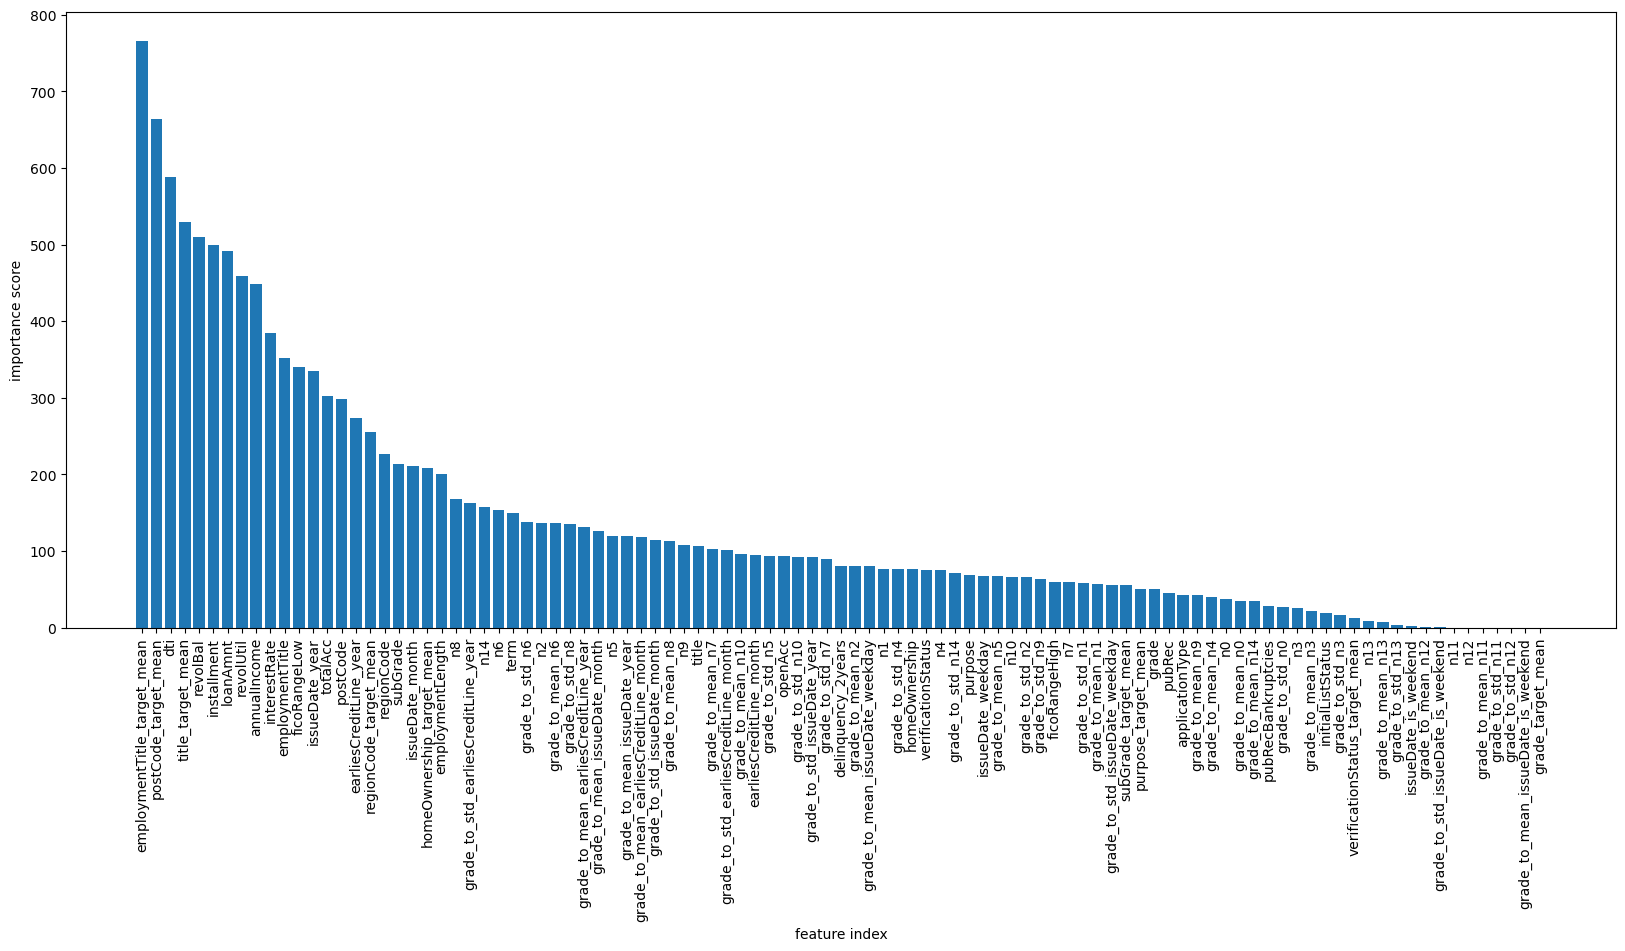

In [125]:
plt.figure(figsize=(20, 8))
bars = plt.bar(range(len(feature_importance_pair)), [x[1] for x in feature_importance_pair])
plt.xticks(range(len(feature_importance_pair)), [x[0] for x in feature_importance_pair], rotation=90)
plt.xlabel('feature index')
plt.ylabel('importance score')
plt.show()
# feature_importance_pair, feature_importance_top

In [128]:
used_features = feature_importance_top[:50]

In [121]:
sample_result = pd.read_csv("./data/sample_submit.csv")
sample_result["isDefault"] = lgb_test
sample_result.to_csv("./data/sample_result_lgb_feat_v8_1.csv", index=False)

## 随机搜惨

In [ ]:
# 随机搜惨
# 设置参数范围
param_dist = {
    'boosting_type': ['gbdt', 'dart'],  # 提升类型  梯度提升决策树（gbdt）和Dropouts meet Multiple Additive Regression Trees（dart）
    'objective': ['binary'],  # 目标；二分类和多分类
    'num_leaves': range(20, 150),  # 叶子节点数量
    'learning_rate': [0.01, 0.05, 0.1],  # 学习率
    'feature_fraction': [0.6, 0.8, 1.0],  # 特征采样比例
    'bagging_fraction': [0.6, 0.8, 1.0],  # 数据采样比例
    'bagging_freq': range(0, 80),  # 数据采样频率
    'verbose': [-1]  # 是否显示训练过程中的详细信息，-1表示不显示
}

# 初始化模型
model = lgb.LGBMClassifier()


# 使用随机搜索进行参数调优
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist, # 参数组合
                                   n_iter=100, 
                                   cv=5, # 5折交叉验证
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)
# 模型训练
random_search.fit(train_data, target)

# 输出最佳参数
print("Best parameters found: ", random_search.best_params_)

In [27]:
# sample_result = pd.read_csv("./data/sample_submit.csv")
# sample_result["isDefault"] = lgb_test
# sample_result.to_csv("./data/sample_result_lgb_feat_v4.csv", index=False)

## 模型融合

In [134]:
## 加权融合
lgb_result = pd.read_csv("./data/sample_result_lgb.csv")
lgb_v2_result = pd.read_csv("./data/sample_result_lgb_v2.csv")
xgb_result = pd.read_csv("./data/sample_result_xgb.csv")
cat_result = pd.read_csv("./data/sample_result_cat.csv")

lgb_result["isDefault"] = (lgb_result["isDefault"] + lgb_v2_result["isDefault"] \
                        + xgb_result["isDefault"] + cat_result["isDefault"]) / 4
lgb_result.to_csv("./data/sample_result_ensemble.csv")